In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 484782614925910008, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1724924758951803396
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [2]:
import pandas as pd

df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')

In [3]:
import cv2
import csv
import os
import math 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from tqdm.notebook import tqdm
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import random 
from ipywidgets import interact
from sklearn.preprocessing import Normalizer
import pickle
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import time
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import tensorflow as tf
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image


In [ ]:
filename_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_OD.sav'
filename_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_OC.sav'
model_OD_SP = pickle.load(open(filename_OD, 'rb'))
model_OC_SP = pickle.load(open(filename_OC, 'rb'))
# Open pca and scaler model
filename_pca_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca_OD.pkl'
filename_scaler_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler_OD.pkl'
pca_OD = pickle.load(open(filename_pca_OD,'rb'))
scaler_OD = pickle.load(open(filename_scaler_OD, 'rb'))

filename_pca_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca_OC.pkl'
filename_scaler_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler_OC.pkl'
pca_OC = pickle.load(open(filename_pca_OC,'rb'))
scaler_OC = pickle.load(open(filename_scaler_OC, 'rb'))

sp_df_OD = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpiksel_OD_100.json')
sp_df_OC = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpiksel_OC_100.json')

In [41]:
model_OD = tf.keras.models.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic fixed',custom_objects={'fscore':fscore})
model_OC = tf.keras.models.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic fixed',custom_objects={'fscore':fscore})

In [42]:
filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/ROItemplate.png'
template_image = cv2.imread(filename, 0)

In [ ]:
!pip install scikit-image==0.18.1

     |████████████████████████████████| 29.2MB 101kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [ ]:
import skimage
print(skimage.__version__)

0.18.1


# Semua Fungsi Algoritma

In [4]:
def saving_image(img, path):
  if os.path.isfile(path):
    os.remove(path)
    cv2.imwrite(path, img)
  else:
    cv2.imwrite(path, img)

In [6]:
# menampilkan gambar
def figure(images, title, coloumn = 3, size = 20):
    
    plt.rcParams["figure.figsize"] = (size,size) #memperbesar gambar
    

    if (len(images) < 3):
      col = len(images)
    else:
      col = coloumn*1

    row = math.ceil(len(images)/col)

    for a in range(len(images)):
      plt.subplot(row,col, a+1), plt.imshow(images[a], cmap = 'gray')
      plt.title(title[a])
      plt.xticks([]), plt.yticks([])
    plt.show()

In [7]:
# merubah GT drishti menjadi citra mask ground truth
def drishtiGT(path, shape):

  file = open(path, 'r')
  coordinates = file.readlines()
  h, w, _ = shape

  # Ekstrak koordinat dari file gt drishti
  for i in range(len(coordinates)):
    y, x = coordinates[i].split(" ")
    coordinates[i] = (int(x), int(y))

  coordinates = np.array(coordinates)
  file.close()

  # inisiasi citra mask ground truth

  mask = np.zeros([h, w], np.uint8)
  mask[coordinates[:, 1],coordinates[:, 0]] = 255
  color = 255
  mask_contour, hierarchy = cv2.findContours(mask, 
  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  mask = np.zeros([h, w], np.uint8)
  # menggambar boundary mask dari data coordinate gt drishti

  cv2.drawContours(mask, mask_contour, -1, color, cv2.FILLED)

  return mask



In [8]:
# fungsi untuk mengkonversi groundtruth REFUGE
def refuGT(path):


  #coming soon
  mask = cv2.imread(path, 0)
  h, w = mask.shape

  #inisialisasi bound
  OD_mask = np.zeros([h, w], np.uint8)
  OC_mask = np.zeros([h, w], np.uint8)

  OD_mask[mask==128] = 255
  OC_mask[mask==0] = 255

  OD_mask = OD_mask + OC_mask



  return OD_mask, OC_mask


In [9]:
def maxima(d_img):
# Input : distance map 
# output : max point map (maxima) 
  height, width = d_img.shape

  maxima = np.zeros(d_img.shape, dtype = int)
  th = d_img.max()/2
  maxima[d_img > th] = 255

  return maxima

In [10]:
def extractcentroids(maxima):
  # mencari centroid dari setiap blob maxima
  centroids = []
  contours, hierarchy  = cv2.findContours(maxima,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  for c in contours:
    # calculate moments for each contour
    M = cv2.moments(c)
    # calculate x,y coordinate of center
    if M["m00"] != 0:
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
      p = [cX, cY]
      centroids.append(p)
    


  return centroids


In [11]:
# put circle in bright region of retinal image
def brightspot (centroid, img, c=None):
  image = img.copy()
  for i in range(len(centroid)):
    image = cv2.circle(image, (centroid[i][0], centroid[i][1]) , 5, (255, 255, 255), -1)
    if i == c:
      cv2.putText(image, "{}".format(i), (centroid[i][0] - 25, centroid[i][1] - 25),cv2.FONT_HERSHEY_SIMPLEX,3, (255, 255, 255), 4)
    else:
      cv2.putText(image, "{}".format(i), (centroid[i][0] - 25, centroid[i][1] - 25),cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 8)

  return image

In [12]:
def rectfromcenter(center, s, h, w):
  x, y = center
  x0 = round(x - 0.5*s)
  x1 = round(x + 0.5*s)
  y0 = round(y - 0.5*s)
  y1 = round(y + 0.5*s)
  dx = (x1 - x0) - 550
  dy = (y1 - y0) - 550
  # penanganan kasus out of image
  if (x0 < 0):
    x1 = x1 + (-x0)
    x0 = 0
    x1 -= dx
  elif (x1 > w-1):
    x0 = x0 - (x1-(w-1))
    x1 = w-1
    x0 += dx
  else:
    x0 += dx

  if (y0 < 0):
    y1 = y1 + (-y0)
    y0 = 0
    y1 -= dy
  elif (y1 > h-1):
    y0 = y0 - (y1-(h-1))
    y1 = (h-1)
    y0 += dy
  else:
    y0 += dy

  return y0, y1, x0, x1

In [13]:
# Fungsi untuk mengekstrak ROI
# input : list centroid, panjang sisi ROI (s), dan image 
# output : ROI image


def ekstrakROI(centroid, s, img):

  h, w = img.shape[:2]
 
  y0, y1, x0, x1 = rectfromcenter(centroid, s, h, w)

  #cropping ROI from source image
  ROI = img[y0:y1, x0:x1]
  koordinat = (y0, y1, x0, x1)

  return ROI, koordinat

In [14]:
def drawMask(mask, src, tipe):

  source  = src.copy()
  idx = np.where(mask == 255)
  idx = list(zip(*idx))
  idx = np.array(idx)

  if tipe == 'kuning':
    source[idx[:, 0], idx[:, 1],0] = 0 #R
    source[idx[:, 0], idx[:, 1],1] = 255 #G
    source[idx[:, 0], idx[:, 1],2] = 255 #B

  elif tipe =='biru':
    source[idx[:, 0], idx[:, 1],0] = 0 #R
    source[idx[:, 0], idx[:, 1],1] = 0 #G
    source[idx[:, 0], idx[:, 1],2] = 255 #B

  elif tipe == 'hijau':
    source[idx[:, 0], idx[:, 1],0] = 0 #B
    source[idx[:, 0], idx[:, 1],1] = 255 #G
    source[idx[:, 0], idx[:, 1],2] = 0 #R

  elif tipe == 'merah':
    source[idx[:, 0], idx[:, 1],0] = 255 #R
    source[idx[:, 0], idx[:, 1],1] = 0 #G
    source[idx[:, 0], idx[:, 1],2] = 0 #B

  elif tipe == None:
    source[idx[:, 0], idx[:, 1],0] = 0 #B
    source[idx[:, 0], idx[:, 1],1] = 255 #G
    source[idx[:, 0], idx[:, 1],2] = 255 #R

  return source

In [15]:
# mengembalikan size Mask OC dan OD menjadi size citra awal
def resizeMask(koordinat, shape, mask):
  yo, yi, xo, xi = koordinat

  mask_temp = np.zeros(shape, np.uint8)

  for y in range(yo, yi):
    for x in range(xo, xi):
      if mask[y-yo][x-xo] == 255:
        mask_temp[y][x] = 255

  return mask_temp

In [16]:
# Fungsi untuk mengekstrak TP, TN, FP, FN dari input yang berbeda
# input : ground truth dan prediksi. kedua objek tersebut harus sama sizenya (uint8)
# output : TP, TN, FP, FN

def checkROI(OD, center):
  # tipe adalah pembeda cara ekstrak TP, TN, FP, dan FN berbentuk int (1,2,3)
  # tipe : 1. OD detection, 2. segmentasi , 3. screening glaucoma

  # print('coming soon')
  batas = 90
  luasgtAsli = np.sum(OD==255)
  ROI, (y0, y1, x0, x1) = ekstrakROI(center, 550, OD)
  luasgtROI = np.sum(ROI==255)
  presentasi = (luasgtROI/ luasgtAsli) * 100

  if presentasi >= batas:
      return True, presentasi
  else:
      return False, presentasi


  


In [17]:
# kalkulasi metrik 
def MetricCalc (gt, pred, tipe):
  # tipe adalah pembeda cara ekstrak TP, TN, FP, dan FN berbentuk int (1,2,3)
  # tipe : 1. untuk OD detection, 2. untuk segmentasi , 3. screening glaucoma
  TP, TN, FP, FN = hitungPred(gt, pred, tipe)

  metrik = {"sen": (TP, (TP+FN)) , "PPV": (TP, TP + FP ), "Fscore" : ((2*TP), (2*TP + FP + FN)), 
            "spe" : ( TN, (TN + FP)), "NPV" : (TN, (TN + FN)),
            "Acc" : ((TP + FN) , ( TP + TN + FP + FN))}

  for hasil in metrik:
    num, denum = metrik[hasil]
    if denum == 0:
      metrik[hasil] = 0
    else :
      metrik[hasil] = round(num/denum, 2)

  return metrik["Fscore"]

In [18]:
def centerofmass(mask):
    contours, _  = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
 
    # calculate moments for each contour
    M = cv2.moments(contours[0])

    # calculate x,y coordinate of center
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        M["m00"] = 0.0000000001
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        
    return (cX, cY)
    

In [19]:
def differenceMap(ROI):
  # Membuat 18 Difference map dari ROI
  ROI_rgb = [ROI[:,:,0],ROI[:,:,1], ROI[:,:,2]]
  diffmap = []
  for i in range(3):
    G = ROI_rgb[i].copy()
    gpA = [G]
    for i in range(8):
      G = cv2.pyrDown(G)
      gpA.append(G)


    C = [1,2,3]
    D = [3, 4]
    for c in C:
      for d in D:
        s = c + d
        h, w = gpA[c].shape[:2]
        fs_c = cv2.resize(gpA[s], (w, h), interpolation = cv2.INTER_NEAREST)
      
        m = abs(gpA[c] - fs_c)
        #resize maps back to original size
        m = cv2.resize(m, (ROI.shape[1], ROI.shape[0]), interpolation = cv2.INTER_NEAREST)
        diffmap.append(m)
  
  return diffmap

def extractTag(gt, mask, area = 'OD'):
    percentage = np.sum(gt[mask==255])/ np.sum(mask==255) * 100
    if percentage >= 98 :
      if area == 'OD':
        tag = 'OD' #daerah OD
      elif area == 'OC':
        tag = 'OC'
    else:
      tag = 'Otherwise' #daerah non OD

    return tag

def extractHistSP(label, images,segments):
    mask = np.zeros((images[0].shape[0], images[0].shape[1]),np.uint8)
    mask[segments==label] = 255
    HIST_map = np.zeros((5, 256), np.uint8)
    for i in range(len(images)):
      HIST_map[i, :],_ = np.histogram(images[i][mask==255].ravel(),256,[0,256])

    #normalize histogram
    # hist_normalizer = Normalizer(norm='l1').fit(HIST_map)
    # HIST_map = hist_normalizer.transform(HIST_map)
    return HIST_map

def extractCSS(map, mask):
    CSS_map = np.zeros((18, 2), np.uint8)
    for i in range(len(map)):
      CSS_map[i, 0] = np.sum(map[i][mask==255])/(np.sum(mask==255)) #mu
      CSS_map[i, 1] = np.sum((map[i][mask==255]-CSS_map[-1, 0])**2)/(np.sum(mask==255)) #var
    return CSS_map

def CSS_vecs(mask, segments, map, CSS_map):
      # search SP neighbors

      CSS_vectors = [0, 0, 0, 0, 0]
      CSS_vectors[0] = CSS_map # assign CSS of current SP 
      try:
        cX, cY = centerofmass(mask)
        SP_value = segments[cY, cX]
        edge_point_x = segments.shape[1] 
        edge_point_y = segments.shape[0]

        neighbors_explored = [0, 0, 0, 0] #initiate neigbors_explored value
        all_neighbors_explored = False
        d = 1 # initiate step 

        #print('x = {}'.format(cX))
        #print('y = {}'.format(cY))
        #print('SP_value = {}'.format(SP_value))
        
        # moving coordinates toward neigbors superpixel
        while not all_neighbors_explored:
            # search first neighbor
            #print('d = {}'.format(d))

            if cX + d < edge_point_x:
              if segments[cY, cX + d] != SP_value and neighbors_explored[0] == 0:
                  label = segments[cY, cX + d]
                  mask_neighbor = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
                  mask_neighbor[segments==label] = 255
                  CSS_vectors[1] = extractCSS(map, mask_neighbor)
                  neighbors_explored[0] = 1

                  #n1 = centerofmass(mask_neighbor)
                  #print('n1 = {}, label = {}'.format(n1, label))

            else:
              neighbors_explored[0] = 1 # handle superpixel on edge of image
              CSS_vectors[1] = np.zeros((18, 2), np.uint8)

              #n1 = (cX,cY)
              

            # search second neigbor
            if cX - d > 0: 
              if segments[cY, cX - d] != SP_value and neighbors_explored[1] == 0:
                label = segments[cY,cX - d]
                
                mask_neighbor = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
                mask_neighbor[segments==label] = 255
                CSS_vectors[2] = extractCSS(map, mask_neighbor)
                neighbors_explored[1] = 1 # checklist if second neighbor is found
                
                #n2 = centerofmass(mask_neighbor)
                #print('n2 = {}, label = {}'.format(n2, label))
            else:
              
              neighbors_explored[1] = 1 # handle superpixel on edge of image
              CSS_vectors[2] = np.zeros((18, 2), np.uint8)
              
              #n2 = (cX,cY)
            # search third neigbor
            if cY + d < edge_point_y:
              if segments[cY+d, cX] != SP_value and neighbors_explored[2] == 0:
                label = segments[cY+d, cX]
                mask_neighbor = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
                mask_neighbor[segments==label] = 255
                CSS_vectors[3] = extractCSS(map, mask_neighbor)
                neighbors_explored[2] = 1 # checklist if second neighbor is found
                
                #n3 = centerofmass(mask_neighbor)
                #print('n3 = {}, label = {}'.format(n3, label))
            else:
              neighbors_explored[2] = 1 # handle superpixel on edge of image
              CSS_vectors[3] = np.zeros((18, 2), np.uint8)
              #n3 = (cX,cY)
            # search forth neigbor
            if cY - d > 0 : 
              
              if segments[cY-d, cX] != SP_value and neighbors_explored[3] == 0:
                label = segments[cY-d, cX]

                mask_neighbor = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
                mask_neighbor[segments==label] = 255
                CSS_vectors[4] = extractCSS(map, mask_neighbor)
                neighbors_explored[3] = 1 # checklist if second neighbor is found
                
                #n4 = centerofmass(mask_neighbor)
                #print('n4 = {}, label = {}'.format(n4, label))
            else:
              neighbors_explored[3] = 1 # handle superpixel on edge of image
              CSS_vectors[4] = np.zeros((18, 2), np.uint8)
              
              #n4 = (cX, cY)
            
            d+= 5 # step of exploration
            
            # if all neigbors explored, then end the exploration
            if 0 not in neighbors_explored:
              all_neighbors_explored = True

        #image = mark_boundaries(ROI, segments)
        #image = segments.copy()
        #image = cv2.circle(image, (cX, cY), 5, (255, 255, 255), -1)
        #image = cv2.circle(image, n1, 5, (255, 255, 255), -1)
        #cv2.putText(image, "1", n1,cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)
        
        #image = cv2.circle(image, n2, 5, (255, 255, 255), -1)
        #cv2.putText(image, "2", n2, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)

        #image = cv2.circle(image, n3, 5, (255, 255, 255), -1)
        #cv2.putText(image, "3", n3,cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)

        #image = cv2.circle(image, n4, 5, (255, 255, 255), -1)
        #cv2.putText(image, "4", n4,cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)
        #plt.imshow(image)
        #plt.show()

        CSS_vectors = np.array(CSS_vectors)
        return CSS_vectors
        
      except:
        print('Problem with finding mask center of mass')
      

In [20]:
def extract_img(ROI):
    # ekstrak citra kanal r, g, b, h dan v sekaligus menerapkan CLAHE untuk kanal rgb
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    r = clahe.apply(ROI[:,:,0])
    g = clahe.apply(ROI[:,:,1])
    b = clahe.apply(ROI[:,:,2])
    ROI = cv2.cvtColor(ROI, cv2.COLOR_RGB2HSV)
    h = ROI[:,:,0]
    s = ROI[:,:,1]
  
    return [r, g, b, h, s]

In [21]:
# Ekstraksi fitur superpixel
def sp_extract_feature4train(ROI, label, segments, gt, area='OD', center_od = None):
  # this function will return features of superpixel input 
  # the features are histogram(HIST) and central surround statistics(CSS)
  # Input criteria
  # 1. RGB format
  # 2. ROI of Optic Disc 550 x 550 pixel
  # 3. Segments image from SLIC
  # Output :
  # Features of superpixel in ROI : HIST and CSS
  # CSS : Ekstrak mean dan std difference map dari setiap SP
  
  # ekstraksi difference map dan ROI pada 5 kanal 
  diffmap = differenceMap(ROI)
  images = extract_img(ROI)
  

  h = images[0].shape[0]
  w = images[0].shape[1]
  # Ekstraksi Fitur HIST dan CSS pada setiap SP
  mask = np.zeros((h, w),np.uint8)
  mask[segments==label] = 255

  # Mendapatkan histogram dari setiap kanal 
  HIST_map = extractHistSP(label, images, segments)

  # menentukan SP adalah daerah OD atau OC atau bukan 
  # Kode dibawah ini hanya dipakai untuk ekstraksi data 
  tag = extractTag(gt, mask, area)

  # Ektraksi CSS pada SP dan 4 tetangganya
  CSS_map = extractCSS(diffmap, mask)
  CSS_vector = CSS_vecs(mask, segments, diffmap, CSS_map)

  # mengkombinasikan seluruh fitur menjadi fitur 1 dimensi
  if area == 'OC':
    xc, yc = center_od
    xj, yj = centerofmass(mask)
    D = np.sqrt(((xc-xj)/h)**2 + ((yc-yj)/w)**2)
    D = np.array([D])
    features = (HIST_map.flatten(), CSS_vector.flatten(), D)
  elif area == 'OD':
    features = (HIST_map.flatten(), CSS_vector.flatten())
  
  combined = np.concatenate(features)
  return combined, tag

  


In [22]:
# Ekstraksi fitur superpixel
def sp_extract_feature(ROI, label, segments, area='OD', center_od=None):
  # this function will return features of superpixel input 
  # the features are histogram(HIST) and central surround statistics(CSS)
  # Input criteria
  # 1. RGB format
  # 2. ROI of Optic Disc 550 x 550 pixel
  # 3. Segments image from SLIC
  # Output :
  # Features of superpixel in ROI : HIST and CSS

  # ekstrak 18x3  difference map dari ROI
  diffmap = differenceMap(ROI)
  
  # ekstrak citra kanal r, g, b, h dan v sekaligus menerapkan CLAHE untuk kanal rgb
  images = extract_img(ROI)

  h = images[0].shape[0] #height of image
  w = images[0].shape[1] # width of image

  # Ekstraksi Fitur HIST dan CSS pada setiap SP
  mask = np.zeros((h, w),np.uint8)
  mask[segments==label] = 255

  # Mendapatkan histogram dari setiap kanal 
  HIST_map = extractHistSP(label, images, segments)

  # menentukan SP adalah daerah OD atau bukan 
  # Kode dibawah ini hanya dipakai untuk ekstraksi data 

  # Ektraksi CSS pada SP dan 4 tetangganya
  CSS_map = extractCSS(diffmap, mask)
  CSS_vector = CSS_vecs(mask, segments, diffmap, CSS_map)

  # mengkombinasikan seluruh fitur menjadi fitur 1 dimensi
  if area == 'OC':
    xc, yc = center_od
    xj, yj = centerofmass(mask)
    D = np.sqrt(((xc-xj)/h)**2 + ((yc-yj)/w)**2)
    D = np.array([D])
    features = (HIST_map.flatten(), CSS_vector.flatten(), D)
  elif area == 'OD':
    features = (HIST_map.flatten(), CSS_vector.flatten())
  
  combined = np.concatenate(features)
  
  return combined

 

In [23]:
def build_feature_normalizer(features):
  HIST = features[:, :1280]
  CSS = features[:, 1280:]
  hist_normalizer = Normalizer(norm='l1').fit(HIST)
  CSS_normalizer = Normalizer(norm='l1').fit(CSS)

  return hist_normalizer, CSS_normalizer

In [24]:
def feature_normalizer(feature, hist_normalizer, CSS_normalizer):
  HIST = feature[:, :1280]
  CSS = feature[:, 1280:]
  HIST_norm = hist_normalizer.transform(HIST)
  CSS_norm = hist_normalizer.transform(CSS)
  normalized = np.concatenate((HIST_norm, CSS_norm), axis=1)
  return normalized

In [25]:
def bounding_box(image, contour):
  # return bounding box of contour containing in image
  # size of image and contour must same
  c = cv2.approxPolyDP(contour, 3, True)
  rectcontour = cv2.boundingRect(c)
  xo, yo, length, hight = rectcontour
  yi = yo + hight
  xi = xo + length
  koordinat = (yo, yi, xo, xi)
  return image[yo:yi+1, xo:xi+1], koordinat

In [26]:
def CDR_calc(OD_mask, OC_mask):
  c_OD = cv2.findContours(OD_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  c_OD = cv2.approxPolyDP(c_OD[0], 3, True)
  c_OC = cv2.findContours(OC_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  c_OC = cv2.approxPolyDP(c_OC[0], 3, True)
  ver_OD, hor_OD = cv2.boundingRect(c_OD)
  ver_OC, hor_OC = cv2.boundingRect(c_OC)

  VCDR = ver_OC/ ver_OD # vertical CDR
  HCDR = hor_OC/ ver_OD # Horizontal CDR
  ACDR = np.sum(OC_mask == 255)/ np.sum(OD_mask == 255) # Area CDR

  return VCDR, HCDR, ACDR

def ISNT_calc(OD_mask, OC_mask):
  NRR = OD_mask - OC_mask # Neuro Retinal Rim
  

In [27]:
# Upload template histogram
def build_histogram_template():
  file = open('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/template histogram.csv', 'r')

  with file:
    read = csv.reader(file)
    hist = list(read)
    histogram_temp = [int(float(x[0])) for x in hist]
    histogram_template = [0] + histogram_temp

  file.close()
  return histogram_template

In [92]:
#make image template

def build_image_template(df, ix_train, num_sample=100, random_state=4):
  ix_dr_gl = np.array([idx for idx in ix_train if idx < 32])
  ix_dr_n = np.array([idx for idx in ix_train if idx >= 32 and idx < 50])
  ix_re_gl = np.array([idx for idx in ix_train if idx >= 50 and idx < 90])
  ix_re_n = np.array([idx for idx in ix_train if idx >= 90 and idx < 450])
  random.Random(random_state).shuffle(ix_dr_gl)
  random.Random(random_state).shuffle(ix_dr_n)
  random.Random(random_state).shuffle(ix_re_gl)
  random.Random(random_state).shuffle(ix_re_n)
  portion = num_sample/len(ix_train)
  ix_dr_gl = ix_dr_gl[:int(len(ix_dr_gl)*portion)]
  ix_dr_n = ix_dr_gl[:int(len(ix_dr_gl)*portion)]
  ix_re_gl = ix_re_gl[:int(len(ix_dr_gl)*portion)]
  ix_re_n = ix_re_n[:int(len(ix_dr_gl)*portion)]
  ix = np.concatenate((ix_dr_gl, ix_dr_n, ix_re_gl, ix_re_n))
  random.Random(random_state).shuffle(ix)

  template_image = np.zeros([550, 550], np.float32)
  for i in ix:
      src = cv2.imread(df['path'][i], 1)
      src = src[:,:,1]
      clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
      src = clahe.apply(src)
      temp, _ = ekstrakROI(df['disc_center'][i], 550, src)
      template_image += temp

  template_image = ((template_image)/len(ix_train))
  template_image = template_image.astype(np.uint8)
  #filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/ROItemplate.png'
  #cv2.imwrite(filename, template_image) 

  return template_image


In [46]:
def index_shuffle(f, random_state=4):
  ix_dr_gl = np.array(list(range(0, 32)))
  ix_dr_n = np.array(list(range(32, 50)))
  ix_re_gl = np.array(list(range(50, 90)))
  ix_re_n = np.array(list(range(90, 450)))
  
  random.Random(random_state).shuffle(ix_dr_gl)
  random.Random(random_state).shuffle(ix_dr_n)
  random.Random(random_state).shuffle(ix_re_gl)
  random.Random(random_state).shuffle(ix_re_n)
  # test_size = 1/k
  # [x*test_size for x in list(range(0, 33, test_size*32))]
  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  
  i = f - 1
  # meta-index for train data
  tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
  tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
  tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
  tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

  # meta-index for test data
  te_dr_gl = list(range(dr_gl[i], dr_gl[i+1])) 
  te_dr_n = list(range(dr_n[i], dr_n[i+1]))
  te_re_gl = list(range(re_gl[i], re_gl[i+1]))
  te_re_n = list(range(re_n[i], re_n[i+1]))

  ix_train = np.concatenate((ix_dr_gl[tr_dr_gl], ix_dr_n[tr_dr_n],
                               ix_re_gl[tr_re_gl], ix_re_n[tr_re_n]))
  ix_test = np.concatenate((ix_dr_gl[te_dr_gl], ix_dr_n[te_dr_n],
                              ix_re_gl[te_re_gl],  ix_re_n[te_re_n]))
  
  random.Random(random_state).shuffle(ix_train)
  random.Random(random_state).shuffle(ix_test)


  return ix_train, ix_test

In [88]:
@interact(i=(0, 450), t = (0, 50))
def testing(i=0, t = 10):    
  src = cv2.imread(df['path'][i], 1)
  img = src[:,:,1]
  h, w = img.shape[:2]
  # CLAHE
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(img)
  blurred = cv2.GaussianBlur(cl_img, (7, 7), 0)
  (T, threshInv) = cv2.threshold(blurred, t , 255, cv2.THRESH_BINARY)
  masked = cv2.bitwise_and(cl_img, cl_img, mask=threshInv)
  plt.figure(figsize=(15, 5))
  plt.subplot(1,3,1),
  plt.hist(cl_img.ravel(),256,[0,256])
  plt.axvline(x=t, color='r')
  plt.subplot(1,3,2),
  plt.imshow(threshInv, cmap='gray')
  plt.subplot(1,3,3),
  plt.imshow(masked, cmap='gray')
  
  plt.show()

interactive(children=(IntSlider(value=0, description='i', max=450), IntSlider(value=10, description='t', max=5…

In [102]:
def padding(img, h, w):
  top = 0
  bottom = h - img.shape[0]
  left = 0
  right = w - img.shape[1]
  value = 0
  borderType = cv2.BORDER_CONSTANT
  result = cv2.copyMakeBorder(img, top, bottom, left, right, borderType, value)
  return result
def lokalisasiOD(src, template_image, with_mask=False, thres_mult=8/3, 
                 clahe_image=False, test=False ):
  # Ekstrak kanal hijau
  img = src[:,:,1]
  h, w = img.shape[:2]
  # CLAHE
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(img)
  blurred = cv2.GaussianBlur(cl_img, (7, 7), 0)
  (T, threshInv) = cv2.threshold(blurred, 10 , 255, cv2.THRESH_BINARY)

  # print('Localizing Optic Disc...')
  if with_mask==False:
    result = cv2.matchTemplate(cl_img, template_image, cv2.TM_CCOEFF_NORMED)
    result = padding(result, h, w)
    result = cv2.bitwise_and(result, result, mask=threshInv)

  elif with_mask==True:
    # Building mask
    # print('Building mask...')
    ret,_ = cv2.threshold(cl_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cons = thres_mult

    # modified otsu thresholding
    th = ret*cons
    _, otsu_img = cv2.threshold(cl_img,th,255,cv2.THRESH_BINARY)

    # Distance Map 
    dist_img = cv2.distanceTransform(otsu_img, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

    # Maximum pixel at distance map
    maxima_img = maxima(dist_img)
    maxima_img = cv2.convertScaleAbs(maxima_img)

    # Ekstrak centroid berpotensi sebagai disc center
    centers = extractcentroids(maxima_img)
    src = brightspot (centers, src)

    brightmask = np.zeros([h, w], np.float32)
    # Build mask for template matching
    for center in centers:
      y0, y1, x0, x1 = rectfromcenter(center, 550, h, w)
      cv2.rectangle(brightmask, (x0, y0), (x1, y1), 1.0, thickness = cv2.FILLED)
    # print('Localizing OD...')
    
    result = cv2.matchTemplate(cl_img, template_image, cv2.TM_CCOEFF_NORMED)
    result = padding(result, h, w)
    result = cv2.bitwise_and(result, result, mask=threshInv)
    result = result*brightmask
    #plt.imshow(masked, cmap='gray')

  (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)
  (startX, startY) = maxLoc
  endX = startX + template_image.shape[1]
  endY = startY + template_image.shape[0]
  disk_center = (round((endX+startX)/2), round((endY+startY)/2))

  
  # draw the bounding box on the image
  if clahe_image:
    ROI, koordinat = ekstrakROI(disk_center, 550, cl_img)
  else:
    ROI, koordinat = ekstrakROI(disk_center, 550, src)
  if test:
    return ROI, koordinat, disk_center, result
  elif not test:
    return ROI, koordinat, disk_center


In [30]:
# Fungsi untuk menyocokan histogram
# input : list koordinat centroid, panjang sisi ROI, citra retina asli, 
# template histogram
# output : koordinat centroid yang diduga centroid dari Optic Disc
def image_template_matching(centroids, s, img, T):
  # img : image
  # R : Correlation formula
  # T : Template image
  R_max = -999
  center = []
  # h, w = img.shape
  # hist_temp = np.array(hist_temp)
  """
  if not centroids:
    result = cv2.matchTemplate(img, T, cv2.TM_SQDIFF_NORMED)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)

    (startX, startY) = minLoc
    endX = startX + template_image.shape[1]
    endY = startY + template_image.shape[0]
    center = (round((endX+startX)/2), round((endY+startY)/2))
  """
  korelasi = []
  #else:
  for i in range(len(centroids)):
      centroid = centroids[i]

      #cropping ROI from source image
      I, _ = ekstrakROI(centroid, s, img)

      # Green channel histogram, 0 : red, 1 : green, 2 : blue
      # hist = cv2.calcHist(ROI, [1], None, [256], [0,256])
      # hist = np.array(hist)
      
      #calc correlation formula
      R = np.sum(T * I)/ np.sqrt(np.sum(T**2) * np.sum(I**2)) # TM_COEFF_NORMED
      korelasi.append(R)
      if R > R_max :
        R_max = R
        center = centroid
  print(centroids)
  print(korelasi)
  print('Korelasi : {}'.format(R_max))
  print('centroid : {}'.format(center))
  return center

In [31]:
def gray2rgb(gray_image):
  h, w = gray_image.shape
  rgb_image = np.zeros((h, w, 3), np.uint8)
  rgb_image[:, :, 0] = gray_image
  rgb_image[:, :, 1] = gray_image
  rgb_image[:, :, 2] = gray_image
  return rgb_image

In [32]:
def encoder_svm(data):
  length_data = len(data)
  encoded = []
  for i in range(length_data):
    if data[i] == 'Otherwise':
      encoded.append(-1)
    else:
      encoded.append(1)

  return encoded

def encoder_cnn(data):
  length_data = len(data)
  encoded = []
  for i in range(length_data):
    if data[i] == 'Otherwise':
      encoded.append(0)
    else:
      encoded.append(1)

  return encoded

In [33]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fscore(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def build_model(train_data, model_type, test_data=None, batch_size=None, 
                num_epoch=None, input_shape=None, kernel='rbf'):
  print('Building model....')

  if model_type=='CNN':
      model = tf.keras.Sequential([
          tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape),
          tf.keras.layers.MaxPool1D(pool_size=2),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(64, activation='relu'),

          tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
          tf.keras.layers.MaxPool1D(pool_size=2),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(64, activation='relu'),
          
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(1, activation='sigmoid')
      ])

      opt = Adam(learning_rate=0.001)
      model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy',
                                                                      f1_m])
      history = model.fit(train_data[0], train_data[1], batch_size=batch_size,
                epochs=num_epoch,validation_data=test_data, verbose=0)
      print('model is done!')
      return model, history
  elif model_type=='SVM':
      model = svm.SVC(kernel=kernel, probability=True)
      model.fit(train_data[0], train_data[1])
      print('model is done!')
      return model



In [34]:
def printing_metric(num_component, f1, train_acc,test_acc, process_time):
    print('Metric for OD superpixel classification')
    print('number of component :{}'.format(num_component))
    print('F1: ', round(f1*100, 2))
    print('Accuracy train : {} %'.format(round(train_acc*100, 2)))
    print('Accuracy dev : {} %'.format(round(test_acc*100, 2)))
    print('testing time : {} s\n\n'.format(process_time))

In [35]:
def model_experiment(sp_df_OD, sp_df_OC, model_type, scaler=True, pca=True, 
                     normalizer=False,var=1, kernel='rbf'):
  # Separating out the features
  X_OD = np.array(sp_df_OD['combined_feature'].tolist())
  # Separating out the target
  y_OD = np.array(sp_df_OD['tag'].tolist())

  # Separating out the features
  X_OC = np.array(sp_df_OC['combined_feature'].tolist())
  # Separating out the target
  y_OC = np.array(sp_df_OC['tag'].tolist())


  if model_type=='SVM':
    y_OD = encoder_svm(y_OD)
    y_OC = encoder_svm(y_OC)
  elif model_type=='CNN':
    y_OD = encoder_cnn(y_OD)
    y_OC = encoder_cnn(y_OC)

  X_train_OD, X_test_OD, y_train_OD, y_test_OD = train_test_split(
    X_OD, y_OD,test_size=0.2, stratify=y_OD, random_state = 4)

  X_train_OC, X_test_OC, y_train_OC, y_test_OC = train_test_split(
    X_OC, y_OC,test_size=0.2, stratify=y_OC, random_state = 4)
    
  # Standardizing the features
  if scaler== True:
      print('Scalling data...')
      scaler_OD = StandardScaler()
      scaler_OC = StandardScaler()

      scaler_OD.fit(X_train_OD)
      scaler_OC.fit(X_train_OC)

      # scalling training and testing OD data (mean = 0, std = 1)
      X_train_OD = scaler_OD.transform(X_train_OD)
      X_test_OD = scaler_OD.transform(X_test_OD)

      # scalling training and testing OC data (mean = 0, std = 1)
      X_train_OC = scaler_OC.transform(X_train_OC)
      X_test_OC = scaler_OC.transform(X_test_OC)
      print('Scalling data done')
  elif normalizer:
      print('Normalize data...')
      hist_normalizer_OD, css_normalizer_OD = build_feature_normalizer(X_train_OD)
      hist_normalizer_OC, css_normalizer_OC = build_feature_normalizer(X_train_OC)
      X_train_OD = feature_normalizer(X_train_OD, hist_normalizer_OD, css_normalizer_OD)
      X_train_OC = feature_normalizer(X_train_OC, hist_normalizer_OC, css_normalizer_OC)
      print('Normalize data done')
  if pca==True:
      print('implementing PCA...')
      # fit pca model to training data
      # desired retaining variance 
      pca_OD = PCA(var) 
      pca_OC = PCA(var) 
      pca_OD.fit(X_train_OD)
      pca_OC.fit(X_train_OC)
      X_train_OD = pca_OD.transform(X_train_OD)
      X_test_OD = pca_OD.transform(X_test_OD)
      X_train_OC = pca_OC.transform(X_train_OC)
      X_test_OC = pca_OC.transform(X_test_OC)
      print('implementing PCA done')

  num_component_OD=len(X_train_OD[0])
  num_component_OC=len(X_train_OC[0])

  if model_type=='SVM':
    print('model type: SVM')
    train_data_OD = (X_train_OD, y_train_OD)
    test_data_OD = (X_test_OD, y_test_OD)
    train_data_OC = (X_train_OC, y_train_OC)
    test_data_OC = (X_test_OC, y_test_OC)
    model_OD = build_model(train_data_OD, model_type='SVM', kernel=kernel)
    model_OC = build_model(train_data_OC, model_type='SVM',kernel=kernel)

    print('Evaluate model...')
    predictions_train_OD = model_OD.predict(X_train_OD)
    predictions_train_OC = model_OC.predict(X_train_OC)
    start_OD = time.time()
    predictions_test_OD = model_OD.predict(X_test_OD)
    end_OD = time.time()
    start_OC = time.time()
    predictions_test_OC = model_OC.predict(X_test_OC)
    end_OC = time.time()

    train_acc_OD = accuracy_score(predictions_train_OD, y_train_OD)
    train_acc_OC = accuracy_score(predictions_train_OC, y_train_OC)
    test_acc_OD = accuracy_score(predictions_test_OD, y_test_OD)
    test_acc_OC = accuracy_score(predictions_test_OC, y_test_OC)
    f1_OD = round(f1_score(predictions_test_OD, y_test_OD), 3)
    f1_OC = round(f1_score(predictions_test_OC, y_test_OC), 3)
    process_time_OD = round((end_OD-start_OD)/len(X_test_OD), 5)
    process_time_OC = round((end_OC-start_OC)/len(X_test_OC), 5)
    print('Evaluate model done\n')
    # Printing metric
    printing_metric(num_component_OD, f1_OD, train_acc_OD,test_acc_OD, process_time_OD)
    printing_metric(num_component_OC, f1_OC, train_acc_OD,test_acc_OC, process_time_OC)
    if pca and scaler:
      return model_OD, model_OC, pca_OD, pca_OC, scaler_OD, scaler_OC
    elif pca and not scaler:
      return model_OD, model_OC, pca_OD, pca_OC
    elif not pca and scaler:
      return model_OD, model_OC, scaler_OD, scaler_OC
    elif not pca and not scaler:
      return model_OD, model_OC
    
    
  elif model_type=='CNN':
    print('model type: CNN')
    X_train_OD = np.array(X_train_OD).reshape(-1, num_component_OD, 1)
    X_test_OD = np.array(X_test_OD).reshape(-1, num_component_OD, 1)
    X_train_OC = np.array(X_train_OC).reshape(-1, num_component_OC, 1)
    X_test_OC = np.array(X_test_OC).reshape(-1, num_component_OC, 1)
    y_train_OD = np.array(y_train_OD)
    y_test_OD = np.array(y_test_OD)
    y_train_OC = np.array(y_train_OC)
    y_test_OC = np.array(y_test_OC)
    num_epochs = 20
    batch_size = 50
    train_data_OD = (X_train_OD, y_train_OD)
    test_data_OD = (X_test_OD, y_test_OD)
    train_data_OC = (X_train_OC, y_train_OC)
    test_data_OC = (X_test_OC, y_test_OC)
    input_shape_OD = (num_component_OD, 1)
    input_shape_OC = (num_component_OC, 1)

    model_OD, history_OD = build_model(train_data_OD, 'CNN', test_data_OD, batch_size=batch_size, 
                num_epoch=num_epochs, input_shape=input_shape_OD)
    model_OC, history_OC = build_model(train_data_OC, 'CNN', test_data_OC, batch_size=batch_size, 
                num_epoch=num_epochs, input_shape=input_shape_OC)

    # Evaluate model
    print('Evaluate model...')
    train_score_OD = model_OD.evaluate(train_data_OD[0], train_data_OD[1], verbose=0)
    train_score_OC = model_OC.evaluate(train_data_OC[0], train_data_OC[1], verbose=0)

    start_OD = time.time()
    score_OD = model_OD.evaluate(test_data_OD[0], test_data_OD[1], verbose=0)
    end_OD = time.time()

    start_OC = time.time()
    score_OC = model_OC.evaluate(test_data_OC[0], test_data_OC[1], verbose=0)
    end_OC = time.time()

    process_time_OD = round((end_OD-start_OD)/len(X_test_OD), 5)
    process_time_OC = round((end_OC-start_OC)/len(X_test_OC), 5)
    train_acc_OD = train_score_OD[1]
    train_acc_OC = train_score_OC[1]
    test_acc_OD = score_OD[1]
    test_acc_OC = score_OC[1]
    f1_OD = score_OD[2]
    f1_OC = score_OC[2]
    print('Evaluate model done\n')
    # Printing metric
    printing_metric(num_component_OD, f1_OD, train_acc_OD,test_acc_OD, process_time_OD)
    printing_metric(num_component_OC, f1_OC, train_acc_OD,test_acc_OC, process_time_OC)
    if pca and scaler:
      return model_OD, model_OC, history_OD, history_OC, pca_OD, pca_OC, scaler_OD, scaler_OC
    elif pca and not scaler:
      return model_OD, model_OC, history_OD, history_OC, pca_OD, pca_OC
    elif not pca and scaler:
      return model_OD, model_OC, history_OD, history_OC, scaler_OD, scaler_OC
    elif not pca and not scaler:
      return model_OD, model_OC, history_OD, history_OC
    

In [36]:
# Circle Hough Transform Model fitting
def ellipsTransform(mask):
  # Select largest contour
  cnts, _= cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
  elips = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
  if len(cnts)>0:
  # Ellipse fitting
    ellipse = cv2.fitEllipse(cnts[0])
    elips = cv2.ellipse(elips, ellipse, 255, cv2.FILLED)
  else:
    elips = mask
  return elips
  

In [37]:
# fungsi untuk segmentasi OC dan OD mvoulana et al
# Input : Region of Interest of OD
# Output : mask of OD dan OC
def segmentation_kmeans(ROI, elips_fit=True):
  # Reshaping the image into a 2D array of pixels and 1 color values (Grayscale)
  pixel_vals = ROI.reshape((-1,1)) 
  

  # Convert to float type 
  pixel_vals = np.float32(pixel_vals)

  #the below line of code defines the criteria for the algorithm to stop running,  
  #which will happen is 100 iterations are run or the epsilon (which is the required accuracy)  
  #becomes 85% 
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 150, 0.95) 
    
  # then perform k-means clustering wit h number of clusters defined as 3 
  #also random centres are initally chosed for k-means clustering 
  k = 5 # dari mvoulana
  retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 

  # convert data into 8-bit values 
  centers = np.uint8(centers)
  segmented_data = centers[labels.flatten()] 
  
  # reshape data into the original image dimensions 
  segmented_image = segmented_data.reshape((ROI.shape)) 
  
  # mengambil label dengan nilai value tertinggi pertama dan kedua
  
  centers.sort()
  max_value = max(centers)
  min_value = min(centers)
  second_value = -999
  for i in range(len(centers)):
    if second_value < centers[i] and max_value > centers[i] :
      second_value = centers[i]
  
  first_label = np.where(centers == max_value)[0]
  second_label = np.where(centers == second_value)[0]
  # last_label = np.where(centers == min_value)[0]

  #inisisasi mask OD dan OC
  OD_kmeans = np.zeros(ROI.shape, np.uint8)
  OC_kmeans = np.zeros(ROI.shape, np.uint8)

  # Vessel_mask = np.zeros(ROI.shape, np.uint8)


  labels = labels.reshape((ROI.shape))
  # Mengisi mask OD dan OC 
  h, w = ROI.shape

  OC_kmeans[labels == first_label] = 255
  OD_kmeans[labels == second_label] = 255

  
  OD_kmeans = OD_kmeans + OC_kmeans


  # operasi morfologi
  kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
  OC_mask = cv2.erode(OC_kmeans, kernel,iterations = 1)
  OD_mask = cv2.erode(OD_kmeans, kernel, iterations = 1)

  OC_mask = cv2.dilate(OC_mask,kernel, iterations = 1)
  OD_mask = cv2.dilate(OD_mask, kernel, iterations = 1)

  OC_mask = cv2.erode(OC_mask, kernel,iterations = 1)
  OD_mask = cv2.erode(OD_mask, kernel, iterations = 1)

  OC_mask = cv2.dilate(OC_mask,kernel, iterations = 1)
  OD_mask = cv2.dilate(OD_mask, kernel, iterations = 1)

  #kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(80,80))
  #OC_mask = cv2.morphologyEx(OC_mask, cv2.MORPH_CLOSE, kernel)
  #OD_mask = cv2.morphologyEx(OD_mask, cv2.MORPH_CLOSE, kernel)

  # Convex hull
  OD = OD_mask.copy()
  OC = OC_mask.copy()
  contoursOD, hierarchyOD = cv2.findContours(OD, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contoursOC, hierarchyOC = cv2.findContours(OC, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  OD_seg = np.zeros([h, w], np.uint8)
  OC_seg = np.zeros([h, w], np.uint8)

  for i in range(len(contoursOD)):
    color = 255
    contoursOD[i] = cv2.convexHull(contoursOD[i], False)
    
    # seleksi contour 
    centers, radius = cv2.minEnclosingCircle(contoursOD[i])
    min_Rad = 50
    if (radius > min_Rad):
      cv2.drawContours(OD_seg, contoursOD, i, color, thickness = cv2.FILLED)

  for i in range(len(contoursOC)):
    color = 255
    contoursOC[i] = cv2.convexHull(contoursOC[i], False)
    
    # seleksi contour 
    centers, radius = cv2.minEnclosingCircle(contoursOC[i])
    min_Rad = 25
    if (radius > min_Rad):
      cv2.drawContours(OC_seg, contoursOC, i, color, thickness = cv2.FILLED)

  # Circle Hough Transform
  if elips_fit:
    OD_seg = ellipsTransform(OD_seg)
    OC_seg = ellipsTransform(OC_seg)

  return OD_seg, OC_seg



In [38]:
def superpixel_segmentation(ROI, model, threshold, model_type='SVM', pca_on=False, 
                           scaler_on=False, pca=None, scaler=None, area='OD',
                           center_od=None, mask=None, numSegments = 100,
                            elips_fit=True):
    #SLIC 
    sigma = 10

    # inisialisasi image segmentasi
    segmentation = np.zeros((ROI.shape[0], ROI.shape[1]), np.float32)

    if area == 'OD':
      segments = slic(ROI, n_segments=numSegments, sigma=sigma, start_label=1)
      labels = np.unique(segments)

      for label in labels:
        feature = sp_extract_feature(ROI=ROI, label=label, segments=segments,
                                    area=area)
        X = [feature]
        if scaler_on==True:
          X = scaler.transform(X)
        if pca_on==True:
          X = pca.transform(X)
            
        if model_type=='CNN':
          X = np.array(X).reshape(1, -1, 1)
          predict = model.predict(X)
          segmentation[segments==label] = predict[0][0]
        elif model_type =='SVM':
          predict = model.predict_proba(X)
          segmentation[segments==label] = predict[0][1]


    elif area == 'OC':
        segments = slic(ROI, n_segments=numSegments, sigma=sigma, mask=mask,
                          start_label=1)
        labels = np.unique(segments)

        for label in labels[1:]:
          feature = sp_extract_feature(ROI=ROI,label=label,segments=segments,
                                        area=area, center_od=center_od)
                  
          X = [feature]
          if scaler_on==True:
            X = scaler.transform(X)
          if pca_on==True:
            X = pca.transform(X)
          if model_type=='CNN':
            X = np.array(X).reshape(1, -1, 1)
            predict = model.predict(X)
            segmentation[segments==label] = predict[0][0]
          elif model_type =='SVM':
            predict = model.predict_proba(X)
            segmentation[segments==label] = predict[0][1]
        

      # Post processing thresholding
    seg_bin = np.array(segmentation >= threshold, np.uint8)

    if elips_fit:
      seg_bin = ellipsTransform(seg_bin)

    return seg_bin

      

In [39]:
def semantic_segmentation(ROI, model, elips_fit=True):
  ROI = resize(ROI, (256, 256, 1), mode = 'constant', preserve_range = True)
  ROI = np.array([ROI/255.0])
  pred = model.predict(ROI)
  seg_bin = np.array(pred > 0.5, np.uint8)
  seg_bin = seg_bin[0].squeeze()
  seg_bin = seg_bin*255

  # ellips fitting
  if elips_fit:
    seg_bin = ellipsTransform(seg_bin)

  return seg_bin

In [40]:
def active_snake(mask, ROI, alpha=0.015, beta=10, gamma=0.001, std=3):
    # active snake
    # Select largest contour
    h, w = mask.shape[:2]
    cnts, _= cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    cnts = np.array(cnts[0]).squeeze()
    # Active disc
    snake = active_contour(gaussian(ROI, std), cnts, alpha=alpha, beta=Beta,
                           gamma=Gamma,coordinates='rc')
    snake = [np.expand_dims(snake, axis = 0).astype('int32')]
    snake_filled = np.zeros((h, w), np.uint8)
    cv2.drawContours(snake, snake_filled, -1, 255, cv2.FILLED)
    return snake

# Testing segmentasi OD dan OC

In [ ]:
@interact(n=(0, 450), segmentation=['kmeans', 'superpixel', 'semantic'])
def testsegment(n=0, segmentation='semantic'):
  # load image and ROI 
  image = cv2.imread(df['path'][n],1)
  ROI_rgb, _ = ekstrakROI(df['disc_center'][n], 550, image)
  ROI_rgb = cv2.cvtColor(ROI_rgb, cv2.COLOR_BGR2RGB)


  # load segmentation ground truth of OD and OC
  gt_OD = cv2.imread(df['path_OD_png'][n], 0)
  gt_OD, _ =  ekstrakROI(df['disc_center'][n], 550, gt_OD)
  gt_OC = cv2.imread(df['path_OC_png'][n], 0)
  gt_OC, _ =  ekstrakROI(df['disc_center'][n], 550, gt_OC)

  center_OD = df['disc_center'][n]

  # OD and OC segmentation 

  if segmentation == 'superpixel':
      ROI, _ = ekstrakROI(df['disc_center'][n], 550, image)
      ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)
      # OD segmentation
      start = time.time()
      OD = superpixel_segmentation(ROI=ROI, model=model_OD_SP, model_type='SVM',
                                  pca_on=True, scaler_on=False, pca=pca_OD,
                                  area='OD', scaler=scaler_OD, numSegments = 100, 
                                  threshold=0.8)



      # OC segmentation

      OC = superpixel_segmentation(ROI=ROI, model=model_OC_SP, model_type='SVM', 
                                  pca_on=True, scaler_on=False, pca=pca_OC,
                                  area='OC', scaler=scaler_OC, center_od=center_OD,
                                  mask=gt_OD, numSegments = 100, threshold=0.5)
      end = time.time()

  elif segmentation == 'semantic':
      start = time.time()
      clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
      cl_img = clahe.apply(image[:, :, 1])
      ROI, _ = ekstrakROI(df['disc_center'][n], 550, cl_img)
      OD = semantic_segmentation(ROI, model_OD)
      OC = semantic_segmentation(ROI, model_OC)
      end = time.time()

  elif segmentation == 'kmeans':
      start = time.time()
      clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
      cl_img = clahe.apply(image[:, :, 1])
      ROI, _ = ekstrakROI(df['disc_center'][n], 550, cl_img)
      OD, OC = segmentation_kmeans(ROI)
      end = time.time()

  # calculate DSC 

  DSC_OD = np.sum(OD[gt_OD==255])*2.0 / (np.sum(gt_OD) + np.sum(OD))
  DSC_OC = np.sum(OC[gt_OC==255])*2.0 / (np.sum(gt_OC) + np.sum(OC))

  # Coloring mask
  OD_contour,_ = cv2.findContours(OD, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  OC_contour,_ = cv2.findContours(OC, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

  # Overlay mask on ROI
  blend_OD = cv2.drawContours(ROI_rgb.copy(), OD_contour, 0, (0, 0, 255), 2)
  blend_OC = cv2.drawContours(ROI_rgb.copy(), OC_contour, 0, (0, 0, 255), 2)

  fig, ax = plt.subplots(1, 2, figsize= (10, 5))
  ax[0].imshow(blend_OD)
  ax[0].contour(gt_OD, colors='w')
  ax[0].text(40, 30, 'DSC = {}'.format(round(DSC_OD, 3)), fontsize='small', color ='w')
  ax[0].set(title='OD segmentation')
  ax[1].imshow(blend_OC)
  ax[1].contour(gt_OC, colors='w')
  ax[1].set(title='OC segmentation')
  ax[1].text(40, 30, 'DSC = {}'.format(round(DSC_OC, 3)), fontsize='small', color ='w')

  print('segmentation time: {:.2f} s'.format(end-start))
    
  plt.show()

interactive(children=(IntSlider(value=0, description='n', max=450), Dropdown(description='segmentation', index…

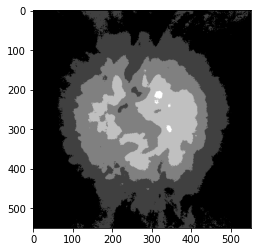

In [94]:
ix_train, ix_test = index_shuffle(f=1, random_state=4)
template_image = build_image_template(df, ix_train, num_sample=100)
plt.imshow(template_image, cmap='gray')

In [98]:
true_idx = []
false_idx = []
detection = []
percent_detection = []
for i in tqdm(range(len(df['path']))):
  path = df["path"][i]
  path_OD = df["path_OD_png"][i]
  path_OC = df["path_OC_png"][i]

  src = cv2.imread(path, 1)
  src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  OD_mask_gt = cv2.imread(path_OD, 0) 
  OC_mask_gt = cv2.imread(path_OC, 0)
  
  ROI, koordinat, disk_center = lokalisasiOD(src, template_image, clahe_image=True)
                                             #with_mask=True, thres_mult=8/3)

  terdeteksi, percentage = checkROI(OD_mask_gt, disk_center)
  detection.append(terdeteksi)
  percent_detection.append(percentage)
  if terdeteksi:
    true_idx.append(i)
  elif not terdeteksi:
    false_idx.append(i)

In [99]:
print('Berhasil: {}'.format(len(true_idx)))
print('Gagal: {}'.format(len(false_idx)))

Berhasil: 390
Gagal: 60


In [104]:
@interact(i=true_idx, n=false_idx, show = ['success', 'failed'])

def roi(i = 0, n = 0, show='success'):

  # input image dan ground truth
  if show=='success':
    path = df["path"][i]
    path_OD = df["path_OD_png"][i]
    path_OC = df["path_OC_png"][i]
  elif show=='failed':
    path = df["path"][n]
    path_OD = df["path_OD_png"][n]
    path_OC = df["path_OC_png"][n]

  src = cv2.imread(path, 1)
  src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  OD_mask_gt = cv2.imread(path_OD, 0) 
  OC_mask_gt = cv2.imread(path_OC, 0)
  
  ROI, koordinat, disk_center, cormap = lokalisasiOD(src, template_image, thres_mult=7/3,
                                             clahe_image=True, test=True, with_mask=False)

  deteksi, percentage = checkROI(OD_mask_gt, disk_center)
  # draw the bounding box on the image
  yo, yi,xo, xi = koordinat
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  img = src[:,:,1]
  img = clahe.apply(img)
  import matplotlib.patches as patches
  rectangle = patches.Rectangle((xo, yo), xi-xo, yi-yo, linewidth=2, 
                                edgecolor='r', facecolor='none')
  y, x = np.where(cormap == np.max(cormap))
  ROI_gt, koordinat = ekstrakROI(disk_center, 550, OD_mask_gt)
  plt.figure(figsize=(12, 24))
  fig, ax = plt.subplots(1, 3, figsize=(12, 24))
  plt.setp(ax, xticks=[], yticks=[])
  ax[0].imshow(ROI_gt, cmap='gray')
  ax[0].text(50, 50, '{} %'.format(round(percentage, 2)), fontsize='medium', color = 'y' )
  ax[1].imshow(img, cmap ='gray')
  ax[1].add_patch(rectangle)
  ax[1].text(90, 90, '{} %'.format(round(percentage, 2)), fontsize='medium', color = 'y' )
  ax[2].imshow(cormap, cmap='gray')
  ax[2].scatter(x, y, s=10, color='r')

  plt.show()


interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17…

In [ ]:
x = np.array([1,2,3,4])

random.Random(4).shuffle(x)
x

array([3, 1, 4, 2])

# **Evaluasi**

In [ ]:
# inisialisasi list metrik dan parameter
detection = []
percent_detection = []
Fscore_OD = []
Fscore_OC = []
fitur = []
prediksi = []
fail_OD = []
fail_OC = []
fail_detection = []
iterates = len(df)
n = 1

In [ ]:
n = 1
iterates = len(df)
result_dic={}
save = True
seg = True
seg_type = 'semantic'
seg_path = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed'
for i in tqdm(range(0,iterates), desc = 'In Process '):

  # input image dan ground truth
  path = df["path"][i]
  path_OD = df["path_OD_png"][i]
  path_OC = df["path_OC_png"][i]
  path_seg_OD = seg_path + '/OD_{}.png'.format(i+1)
  path_seg_OC = seg_path + '/OC_{}.png'.format(i+1)

  src = cv2.imread(path, 1)
  src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  OD_mask_gt = cv2.imread(path_OD, 0) 
  OC_mask_gt = cv2.imread(path_OC, 0)
  
  ### Lokalisasi OD #######################################################

  # draw the bounding box on the image
  
  if seg_type == 'semantic' or seg_type == 'kmeans':
      ROI, koordinat, disk_center = lokalisasiOD(src, template_image, clahe_image=True)
  elif seg_type == 'superpixel':
      ROI, koordinat, disk_center = lokalisasiOD(src, template_image)
    
  detected, percentage= checkROI(OD_mask_gt, disk_center)
  if not detected:
    disk_center = df['disc_center'][i]
    if seg_type == 'semantic' or seg_type == 'kmeans': 
      img = src[:,:,1]
      # CLAHE
      clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
      img = clahe.apply(img)
      disk_center = df['disc_center'][i]
      ROI, koordinat = ekstrakROI(disk_center, 550, img)
    elif seg_type == 'superpixel':
      ROI, koordinat = ekstrakROI(disk_center, 550, src)

  detection.append(detected)
  percent_detection.append(percentage)
  
  if seg:
      if detected:
          ### Segmentasi OD dan OC ##############################################
          if seg_type == 'superpixel':
                try:
                  OD_mask = superpixel_segmentation(ROI=ROI, model=model_OD_SP,model_type='SVM',
                                                  pca_on=True, scaler_on=True, pca=pca_OD,
                                                  scaler=scaler_OD,area='OD', threshold=0.8, 
                                                  numSegments=100)
                except:
                  OD_mask = np.zeros(ROI.shape[:2], np.uint8)
                if len(np.unique(OD_mask)) == 1:
                  fail_OD.append(i)

                # OC segmentation
                try: 
                  OC_mask= superpixel_segmentation(ROI=ROI, model=model_OC_SP, model_type='SVM',
                                                  pca_on=True, scaler_on=True, pca=pca_OC, 
                                                  scaler=scaler_OC, area='OC', center_od=disk_center,
                                                  mask=OD_mask, threshold=0.5, 
                                                  numSegments=100)
                except:
                  OC_mask = np.zeros(ROI.shape[:2], np.uint8)
                if len(np.unique(OC_mask)) == 1:
                  fail_OC.append(i)
          elif seg_type == 'semantic':
                OD_mask = semantic_segmentation(ROI, model_OD)
                OC_mask = semantic_segmentation(ROI, model_OC)
          elif seg_type == 'kmeans':
                OD_mask, OC_mask = segmentation_kmeans(ROI)


          # resize mask dan boundary
          OD_mask = resizeMask(koordinat, src.shape[0:2], OD_mask)
          OC_mask = resizeMask(koordinat, src.shape[0:2], OC_mask)
          if save:
            saving_image(OD_mask, path_seg_OD)
            saving_image(OC_mask, path_seg_OC)
          # Mengecek hasil segmentasi OD dan OC
          Fscore_OD.append(np.sum(OD_mask[OD_mask_gt==255])*2.0 / (np.sum(OD_mask) + np.sum(OD_mask_gt)))
          Fscore_OC.append(np.sum(OC_mask[OC_mask_gt==255])*2.0 / (np.sum(OC_mask) + np.sum(OC_mask_gt)))

      ### Ekstraksi Fitur ###################################################


      ### Klasifikasi Glaukoma ##############################################


      elif detected==False:
        fail_detection.append(i)
        Fscore_OD.append(-1)
        Fscore_OC.append(-1)


  if i == n*100:
        result = pd.DataFrame({"detection_rate":detection,
                              "percent_detection" : percent_detection,
                              "Fscore_OD": Fscore_OD, "Fscore_OC":Fscore_OC})
        result.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/result.json')
        n+=1

if seg:
  result = pd.DataFrame({"detection_rate":detection,
                        "percent_detection" : percent_detection,
                        "Fscore_OD": Fscore_OD, "Fscore_OC":Fscore_OC})
  result.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/result.json')
elif seg==False:
  result = pd.DataFrame({"detection_rate":detection,
                          "percent_detection" : percent_detection})


In [ ]:
@interact(i=(0, 450))
def show_groundtruth(i=0):
  
  mask_OD_gt = cv2.imread(df['path_OD_png'][i], 0)
  mask_OC_gt = cv2.imread(df['path_OC_png'][i], 0)
  mask_OD = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OD_{}.png'.format(i+1), 0)
  mask_OC = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OC_{}.png'.format(i+1), 0)
  h, w = mask_OD_gt.shape[:2]
  mask_OD_gt_show = np.zeros((h, w, 3), np.uint8)
  mask_OD_show = np.zeros((h, w, 3), np.uint8)
  mask_OC_gt_show = np.zeros((h, w, 3), np.uint8)
  mask_OC_show = np.zeros((h, w, 3), np.uint8)

  mask_OD_gt_show[mask_OD_gt==255] = (255, 0, 0)
  mask_OD_show[mask_OD==255] = (0, 0, 255)

  mask_OC_gt_show[mask_OC_gt==255] = (255, 0, 0)
  mask_OC_show[mask_OC==255] = (0, 0, 255)

  DSC_OD = np.sum(mask_OD[mask_OD_gt==255])*2.0/(np.sum(mask_OD) + np.sum(mask_OD_gt))
  DSC_OC = np.sum(mask_OC[mask_OC_gt==255])*2.0/(np.sum(mask_OC) + np.sum(mask_OC_gt))

  plt.figure(figsize=(10, 10))
  plt.subplot(121),
  plt.imshow(mask_OD_gt_show, interpolation='none')
  plt.imshow(mask_OD_show, interpolation='none', alpha=0.35)
  plt.text(100, 100, 'DSC: {:.3f}'.format(DSC_OD), size='small', color='w')
  plt.subplot(122),
  plt.imshow(mask_OC_gt_show, interpolation='none')
  plt.imshow(mask_OC_show, interpolation='none', alpha=0.35)
  plt.text(100, 100, 'DSC: {:.3f}'.format(DSC_OC), size ='small', color='w')
  plt.show()

interactive(children=(IntSlider(value=0, description='i', max=450), Output()), _dom_classes=('widget-interact'…

In [ ]:
result=pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/result.json')

In [ ]:
ix_train, ix_test = index_shuffle(f=1, random_state=4)

In [ ]:
percent_detection = result['percent_detection'][ix_test]

In [ ]:
delix = result.index[result['Fscore_OD']==-1].tolist()
dx_tr = []
dx_ts = []
for ix in delix:
  if ix in ix_train:
    dx = np.where(ix_train == ix)
    dx_tr.append(dx)
  if ix in ix_test:
    dx = np.where(ix_test == ix)
    dx_ts.append(dx)

ix_train_f1 = np.delete(ix_train, dx_tr)
ix_test_f1 = np.delete(ix_test, dx_ts)
ix_f1 = np.concatenate((ix_train_f1, ix_test_f1))

In [ ]:
percent_detection = result['percent_detection']
OD_result = result['Fscore_OD'][ix_f1] 
OD_train = result['Fscore_OD'][ix_train_f1]
OD_test = result['Fscore_OD'][ix_test_f1]
OC_result = result['Fscore_OC'][ix_f1]
OC_train = result['Fscore_OC'][ix_train_f1]
OC_test = result['Fscore_OC'][ix_test_f1]
data_OD_f1 =  [OD_result, OD_train, OD_test]
data_OC_f1 =  [OC_result, OC_train, OC_test]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


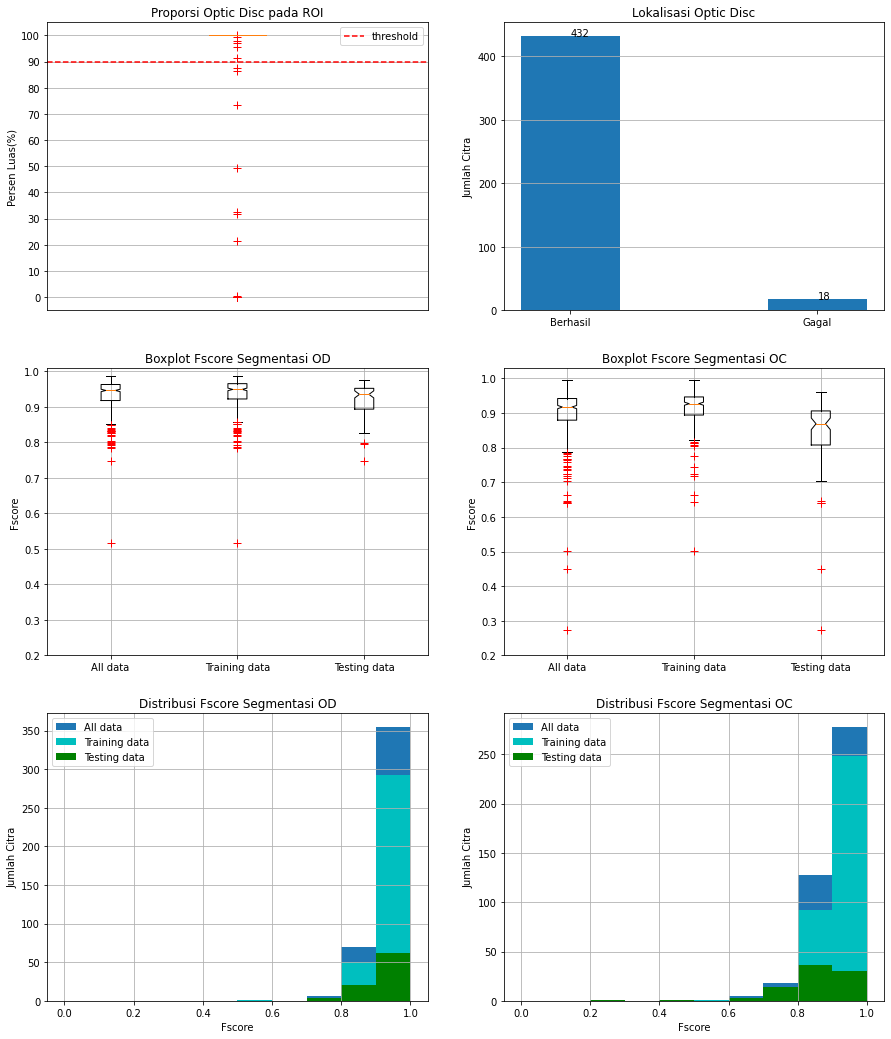

In [ ]:
plt.figure(figsize=(15, 18))
flierprops = dict(marker='+', markerfacecolor='g', markersize=8,
                  linestyle='none', markeredgecolor='r')
plt.subplot(3,2,1), plt.boxplot(percent_detection, flierprops=flierprops)
plt.grid()
plt.yticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.ylabel('Persen Luas(%)')
plt.axhline(90, color = 'r', linestyle = '--', label = 'threshold')
plt.legend()
plt.xticks([])
plt.title('Proporsi Optic Disc pada ROI')

count_true = sum(result['detection_rate'] == True)
count_false = sum(result['detection_rate'] == False)
label = ('Berhasil', 'Gagal')
lokalisasi = (count_true, count_false)
x_coords = np.array([0, 0.5])
plt.subplot(3,2,2), plt.bar(x_coords, lokalisasi,  tick_label = label, width = 0.2)
plt.grid(axis ='y')
plt.text(x_coords[0], count_true, '{}'.format(count_true), fontsize='medium' )
plt.text(x_coords[1], count_false, '{}'.format(count_false), fontsize='medium' )
plt.ylabel('Jumlah Citra')
plt.title('Lokalisasi Optic Disc')

#bins_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
flierprops = dict(marker='+', markerfacecolor='g', markersize=8,
                  linestyle='none', markeredgecolor='r')
plt.subplot(3,2,3), plt.boxplot(data_OD_f1, notch=True, widths=0.15, flierprops=flierprops)
plt.grid()
plt.ylabel('Fscore')
plt.yticks(ticks=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks(ticks=[1,2,3], labels=['All data', 'Training data', 'Testing data'])
plt.title('Boxplot Fscore Segmentasi OD')

plt.subplot(3,2,4), plt.boxplot(data_OC_f1, notch=True, widths=0.15,flierprops=flierprops)
plt.grid()
plt.ylabel('Fscore')
plt.yticks(ticks=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks(ticks=[1,2,3], labels=['All data', 'Training data', 'Testing data'])
plt.title('Boxplot Fscore Segmentasi OC')

bins_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
plt.subplot(3,2,5), 
plt.hist(OD_result, bins=bins_list, label='All data')
plt.hist(OD_train, bins=bins_list, color='c', label='Training data')
plt.hist(OD_test, bins=bins_list, color='g', label='Testing data')
plt.grid()
plt.ylabel('Jumlah Citra')
plt.xlabel('Fscore')
plt.legend()
plt.title('Distribusi Fscore Segmentasi OD')

plt.subplot(3,2,6),
plt.hist(OC_result, bins=bins_list, label='All data')
plt.hist(OC_train, bins=bins_list, color='c', label='Training data')
plt.hist(OC_test, bins=bins_list, color='g', label='Testing data')
plt.grid()
plt.ylabel('Jumlah Citra')
plt.xlabel('Fscore')
plt.legend()
plt.title('Distribusi Fscore Segmentasi OC')


plt.show()

# Aquiring data: Ekstraksi fitur superpixel





In [ ]:
#Ekstraksi fitur Superpixel

tags_OD = []
tags_OC = []
combined_features_OD = []
combined_features_OC = []
index_refuge = list(range(50, 450))
index_drishti = list(range(0, 50))
random.Random(5).shuffle(index_refuge)
random.Random(5).shuffle(index_drishti)
idx_refuge = index_refuge[:80]
idx_drishti = index_drishti[:20]
idx = np.concatenate((idx_refuge, idx_drishti))

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
for i in tqdm(idx, desc = 'Ekstraksi fitur Superpiksel: '):
  center_OD = df['disc_center'][i]
  image = cv2.imread(df['path'][i], 1)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  ROI, _ = ekstrakROI(center_OD, 550, image)
  gt_OD, _ = ekstrakROI(center_OD, 550, cv2.imread(df['path_OD_png'][i], 0))
  gt_OC, _ = ekstrakROI(center_OD, 550, cv2.imread(df['path_OC_png'][i], 0))

  gt_OD_rgb = gray2rgb(gt_OD)
  gt_OC_rgb = gray2rgb(gt_OC)
  
  gt_cnts_OD, _ = cv2.findContours(gt_OD, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  gt_cnts_OD = np.array(gt_cnts_OD[0]).squeeze()
  gt_cnts_OC, _ = cv2.findContours(gt_OC, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  gt_cnts_OC = np.array(gt_cnts_OC[0]).squeeze()

  numSegments = 100
  segments_OD = slic(gt_OD_rgb, n_segments = numSegments, sigma = 1, 
                     start_label = 1)
  segments_OC = slic(gt_OC_rgb, n_segments = numSegments, sigma = 1, mask=gt_OD,
                     start_label = 1)
  
  labels_OD = np.unique(segments_OD)
  labels_OC = np.unique(segments_OC)
  max_len = max([len(labels_OD), len(labels_OC)])


  for i in range(max_len):
    if max_len == len(labels_OD):
      cf_OD, tag_OD = sp_extract_feature4train(ROI, labels_OD[i], segments_OD,
                                               gt_OD, area = 'OD')
      combined_features_OD.append(cf_OD)
      tags_OD.append(tag_OD)
      if i < len(labels_OC):
        if labels_OC[i] > 1: # skipping first label in slic OC
          cf_OC, tag_OC = sp_extract_feature4train(ROI, labels_OC[i], segments_OC,
                                                  gt_OC, area = 'OC',
                                                  center_od= center_OD)
          combined_features_OC.append(cf_OC)
          tags_OC.append(tag_OC)
    
    if max_len == len(labels_OC):
      if labels_OC[i] > 1: # skipping first label in slic OC
        cf_OC, tag_OC = sp_extract_feature4train(ROI, labels_OC[i], segments_OC,
                                                  gt_OC, area = 'OC',
                                                  center_od= center_OD)
        combined_features_OC.append(cf_OC)
        tags_OC.append(tag_OC)
      if i < len(labels_OD) :
        cf_OD, tag_OD = sp_extract_feature4train(ROI, labels_OD[i], segments_OD,
                                                 gt_OD, area = 'OD')
                                                 
        combined_features_OD.append(cf_OD)
        tags_OD.append(tag_OD)
        



In [ ]:
sp_df_OD = pd.DataFrame({'combined_feature': pd.Series(combined_features_OD), 'tag':pd.Series(tags_OD)})
sp_df_OC = pd.DataFrame({'combined_feature': pd.Series(combined_features_OC), 'tag':pd.Series(tags_OC)})

In [ ]:
sp_df_OD.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpiksel_OD_100.json')
sp_df_OC.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpiksel_OC_100.json')

In [ ]:
sp_df_OD = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpiksel_OD_100.json')
sp_df_OC = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpiksel_OC_100.json')

In [ ]:
sp_df_OC.head()

,combined_feature,tag
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Otherwise
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Otherwise
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Otherwise
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Otherwise
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Otherwise


In [ ]:
sp_df_OC.head()

,combined_feature,tag
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Otherwise
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Otherwise
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Otherwise
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Otherwise
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Otherwise


In [ ]:
sp_df_OC['tag'].value_counts()

Otherwise    8785
OC           4951
Name: tag, dtype: int64


# Exploratory Data Analysis for SP

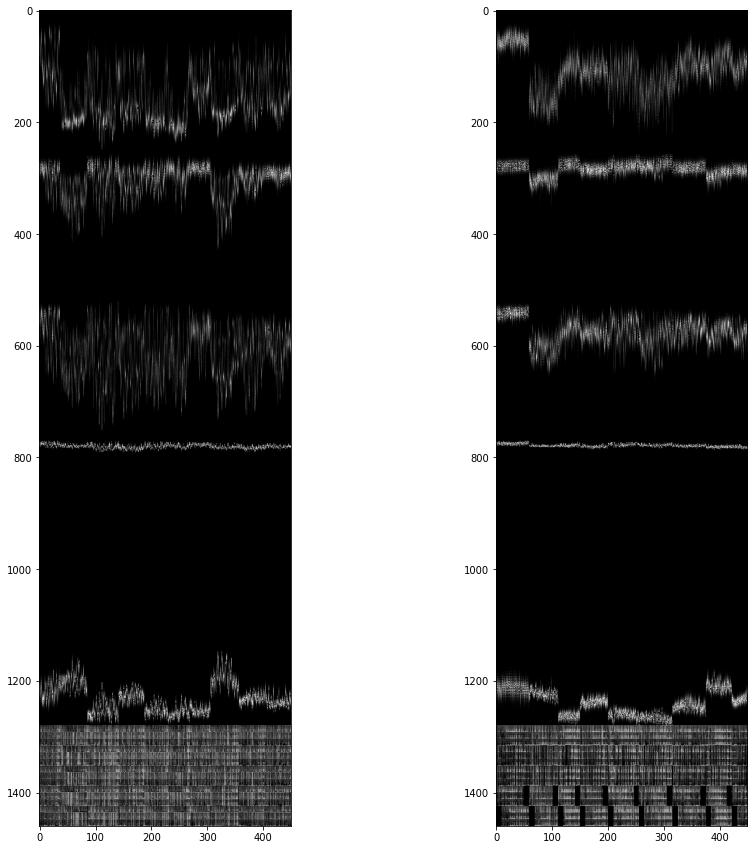

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)
feature_map_OD = []
feature_map_nonOD = []
for i in range(450):
  feature_map_OD.append(np.concatenate((OD_df['HIST'][i].flatten(), OD_df['CSS_vec'][i].flatten())))
  feature_map_nonOD.append(np.concatenate((nonOD_df['HIST'][i].flatten(), nonOD_df['CSS_vec'][i].flatten())))
feature_map_OD = np.array(feature_map_OD).T
feature_map_nonOD = np.array(feature_map_nonOD).T
plt.subplot(121), plt.imshow(feature_map_OD, cmap='gray')
plt.subplot(122),plt.imshow(feature_map_nonOD, cmap='gray')
plt.show()

In [ ]:
def var_segment_OD(numSegments, sigma, ROI, segments_OD, contour_OD):
  segments_OD = slic(ROI, n_segments = numSegments, sigma = sigma, start_label = 1)
  OD_segment = mark_boundaries(ROI, segments_OD)
  OD_segment = cv2.drawContours(OD_segment, contour_OD, 0, (1, 1, 1), 1)
  return OD_segment

def var_segment_OC(numSegments, sigma, ROI, segments_OC, contour_OC, mask):
  segments_OC = slic(ROI, n_segments = numSegments, sigma = sigma, mask=mask, start_label = 1)
  OC_segment = mark_boundaries(ROI, segments_OC)
  OC_segment = cv2.drawContours(OC_segment, contour_OC, 0, (1, 1, 1), 1)
  return OC_segment

In [ ]:
OD_idx = [x for x in range(len(sp_df_OD)) if sp_df_OD['tag'][x]=='OD']
non_OD_idx = [x for x in range(len(sp_df_OD)) if sp_df_OD['tag'][x]=='Otherwise']
OC_idx = [x for x in range(len(sp_df_OC)) if sp_df_OC['tag'][x]=='OC']
non_OC_idx = [x for x in range(len(sp_df_OC)) if sp_df_OC['tag'][x]=='Otherwise']

In [ ]:
@interact(OD=OD_idx, non_OD=non_OD_idx, OC=OC_idx, non_OC=non_OC_idx)

def histogram(OD=0, non_OD=0, OC=0, non_OC=0):
  # Check feature histogram
  feature_OD = sp_df_OD['combined_feature'][OD]
  feature_non = sp_df_OD['combined_feature'][non_OD]
  scaled_feature_OD = scaler_OD.transform([feature_OD])
  scaled_feature_non = scaler_OD.transform([feature_non])

  # Check feature histogram
  feature_OC = sp_df_OC['combined_feature'][OC]
  feature_non_C = sp_df_OC['combined_feature'][non_OC]
  scaled_feature_OC = scaler_OC.transform([feature_OC])
  scaled_feature_non_C = scaler_OC.transform([feature_non_C])

  fig, ax = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(15, 10))
  ax[0, 0].plot(feature_OD, color='b', label='OD')
  ax[0, 0].plot(feature_non, color='r', label='non OD')
  ax[0, 0].set(title='feature OD')
  ax[0, 0].legend()
  ax[0, 1].plot(scaled_feature_OD[0], color='b', label='OD')
  ax[0, 1].plot(scaled_feature_non[0], color='r', label='non OD')
  ax[0, 1].set(title='scaled feature OD')
  ax[0, 1].legend()

  ax[1, 0].plot(feature_OC, color='b', label='OC')
  ax[1, 0].plot(feature_non_C, color='r', label='non OC')
  ax[1, 0].set(title='feature OC')
  ax[1, 0].legend()
  ax[1, 1].plot(scaled_feature_OC[0], color='b', label='OC')
  ax[1, 1].plot(scaled_feature_non_C[0], color='r', label='non OC')
  ax[1, 1].set(title='scaled feature OC')
  ax[1, 1].legend()


  plt.show()


interactive(children=(Dropdown(description='OD', options=(22, 23, 24, 28, 33, 34, 35, 36, 42, 43, 44, 45, 46, …

# Training model with PCA

In [ ]:
# Separating out the features
X_OD = sp_df_OD['combined_feature'].tolist()
# Separating out the target
y_OD = sp_df_OD['tag'].tolist()

# Separating out the features
X_OC = sp_df_OC['combined_feature'].tolist()
# Separating out the target
y_OC = sp_df_OC['tag'].tolist()


In [ ]:
model_OD, model_OC, pca_OD, pca_OC, scaler_OD, scaler_OC = model_experiment(
    sp_df_OD, sp_df_OC, model_type='SVM', scaler=False, pca=False, normalizer=True, 
    var=0.91, kernel='linear')

Normalize data...
Normalize data done
model type: SVM
Building model....
model is done!
Building model....
model is done!
Evaluate model...
Evaluate model done

Metric for OD superpixel classification
number of component :1460
F1:  66.2
Accuracy train : 87.82 %
Accuracy dev : 82.58 %
testing time : 0.0081 s


Metric for OD superpixel classification
number of component :1461
F1:  62.7
Accuracy train : 87.82 %
Accuracy dev : 76.76 %
testing time : 0.01002 s




ValueError: ignored

In [ ]:
# Save pca and scaler model
filename_pca_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca_OD.pkl'
filename_scaler_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler_OD.pkl'
# Save pca and scaler model
filename_pca_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca_OC.pkl'
filename_scaler_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler_OC.pkl'

pickle.dump(pca_OD, open(filename_pca_OD,"wb"))
# pickle.dump(scaler_OD, open(filename_scaler_OD,"wb"))

pickle.dump(pca_OC, open(filename_pca_OC,"wb"))
# pickle.dump(scaler_OC, open(filename_scaler_OC,"wb"))

In [ ]:
# Open pca and scaler model
filename_pca_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca_OD.pkl'
filename_scaler_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler_OD.pkl'
pca_OD = pickle.load(open(filename_pca_OD,'rb'))
scaler_OD = pickle.load(open(filename_scaler_OD, 'rb'))

filename_pca_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca_OC.pkl'
filename_scaler_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler_OC.pkl'
pca_OC = pickle.load(open(filename_pca_OC,'rb'))
scaler_OC = pickle.load(open(filename_scaler_OC, 'rb'))

In [ ]:
filename_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_OD.sav'
filename_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_OC.sav'
pickle.dump(model_OD, open(filename_OD, 'wb'))
pickle.dump(model_OC, open(filename_OC, 'wb'))

In [ ]:
filename_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_OD.sav'
filename_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_OC.sav'
model_OD = pickle.load(open(filename_OD, 'rb'))
model_OC = pickle.load(open(filename_OC, 'rb'))

# Training and test model

In [ ]:
import pickle
# save the model to disk
filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_svm_proba_pca.sav'
pickle.dump(model_svm_proba, open(filename, 'wb'))

In [ ]:
predictions = model_svm_proba.predict(X_test)
print(predictions[0])

-1


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy: ', round(accuracy_score(predictions, y_test), 3))
print('Precision: ', round(precision_score(predictions, y_test), 3))
print('Recall: ', round(recall_score(predictions, y_test), 3))
print('F1: ', round(f1_score(predictions, y_test), 3))

Accuracy:  0.918
Precision:  0.837
Recall:  0.933
F1:  0.882


In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print(f'True Positive: {tp}\nTrue Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}')

True Positive: 752
True Negative: 1505
False Positive: 62
False Negative: 163


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

scores = model_svm_proba.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, scores, pos_label=True)
auc = roc_auc_score(y_test, scores)

In [ ]:
print('Area Under Curve = {}'.format(round(auc, 2)))
plt.rcParams["figure.figsize"] = (7,5)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr, tpr)
plt.show()

# Model CNN

In [ ]:
# Separating out the features
X_OD = sp_df_OD['combined_feature'].tolist()
# Separating out the target
y_OD = sp_df_OD['tag'].tolist()

# Separating out the features
X_OC = sp_df_OC['combined_feature'].tolist()
# Separating out the target
y_OC = sp_df_OC['tag'].tolist()


In [ ]:
def encoder(data):
  length_data = len(data)
  encoded = []
  for i in range(length_data):
    if data[i] == 'Otherwise':
      encoded.append(0)
    else:
      encoded.append(1)

  return encoded

In [ ]:
# encoding labels of OD
y_OD = encoder(y_OD)

# encoding labels of OC
y_OC = encoder(y_OC)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_OD, X_test_OD, y_train_OD, y_test_OD = train_test_split(
    X_OD, y_OD,test_size=0.2, stratify=y_OD, random_state = 4)

X_train_OC, X_test_OC, y_train_OC, y_test_OC = train_test_split(
    X_OC, y_OC,test_size=0.2, stratify=y_OC, random_state = 4)


In [ ]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
scaler_OD = StandardScaler()
scaler_OC = StandardScaler()

scaler_OD.fit(X_train_OD)
scaler_OC.fit(X_train_OC)

# scalling training and testing OD data (mean = 0, std = 1)
X_train_OD = scaler_OD.transform(X_train_OD)
X_test_OD = scaler_OD.transform(X_test_OD)

# scalling training and testing OC data (mean = 0, std = 1)
X_train_OC = scaler_OC.transform(X_train_OC)
X_test_OC = scaler_OC.transform(X_test_OC)

In [ ]:
X_train_OD = np.array(X_train_OD.reshape(-1, 1460, 1))
X_test_OD = np.array(X_test_OD.reshape(-1, 1460, 1))
X_train_OC = np.array(X_train_OC.reshape(-1, 1461, 1))
X_test_OC = np.array(X_test_OC.reshape(-1, 1461, 1))
y_train_OD = np.array(y_train_OD)
y_test_OD = np.array(y_test_OD)
y_train_OC = np.array(y_train_OC)
y_test_OC = np.array(y_test_OC)

In [ ]:
import tensorflow as tf
model_nn_OD = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(1460, 1)),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
from keras.optimizers import SGD, Adam
opt = Adam(learning_rate=0.001)
model_nn_OD.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model_nn_OD.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1459, 64)          192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 729, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 729, 64)           0         
_________________________________________________________________
dense (Dense)                (None, 729, 64)           4160      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 728, 64)           8256      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 364, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 364, 64)           0

In [ ]:
num_epochs = 30
batch = 50
history = model_nn_OD.fit(X_train_OD, y_train_OD, batch_size=batch, epochs=num_epochs, validation_data=(X_test_OD, y_test_OD), verbose=1)

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,5)
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history_OC.history['accuracy']
val_acc=history_OC.history['val_accuracy']
loss=history_OC.history['loss']
val_loss=history_OC.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


In [ ]:
# Evaluating the model on the training and testing set
score = model_nn_OD.evaluate(X_train_OD, y_train_OD, verbose=0)
print("Training Accuracy: ", score[1])

score = model_nn_OD.evaluate(X_test_OD, y_test_OD, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9782850742340088
Testing Accuracy:  0.9599332213401794


In [ ]:
model_nn_OD.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_nnmodel_OD.h5')

In [ ]:
import tensorflow as tf
model_OD = tf.keras.models.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_nnmodel_OD.h5')

In [ ]:
import tensorflow as tf
model_nn_OC = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(1461, 1)),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
from keras.optimizers import SGD, Adam
opt = Adam(learning_rate=0.001)
model_nn_OC.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model_nn_OC.summary()

In [ ]:
num_epochs = 20
batch = 50
history = model_nn_OC.fit(X_train_OC, y_train_OC, batch_size=batch, epochs=num_epochs, validation_data=(X_test_OC, y_test_OC), verbose=1)

<Figure size 576x360 with 0 Axes>

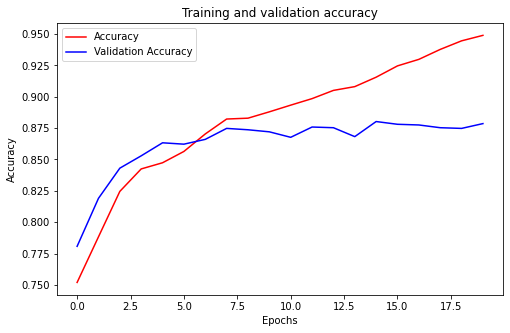

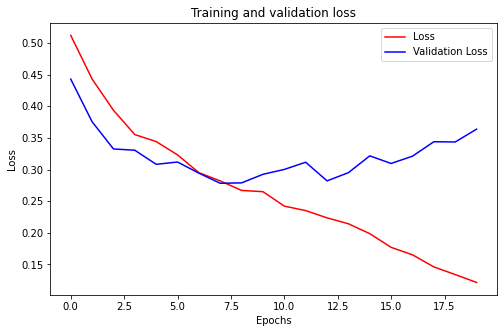

<Figure size 576x360 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


In [ ]:
model_nn_OC.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_nnmodel_OC.h5')

# Input Ground Truth


In [ ]:
"""
# fungsi untuk mengkonversi groundtruth RIGA
def rigaGT(path, shape=None):
  import cv2
  import numpy as np
  from matplotlib import pyplot as plt 

  #coming soon
  mask = cv2.imread(path, 1)
  print(type(mask))
  h, w, _ = mask.shape
  
  idx = np.where(mask == [46, 49, 68])
  idx = list(zip(*idx))
  idx = np.array(idx)

  boundary = np.zeros([h, w], np.uint8)

  boundary[idx[:, 0], idx[:, 1]] = 255

  output = cv2.connectedComponentsWithStats(boundary, cv2.CV_32S)
  (numLabels, labels, stats, centroids) = output

  componentMask = (labels == 100).astype("uint8") * 255

  print((h, w))
  print(labels.shape)
  print(numLabels)
  plt.subplot(131), plt.imshow(boundary, cmap = 'gray')
  plt.subplot(132), plt.imshow(labels, cmap = 'gray')
  plt.subplot(133), plt.imshow(componentMask, cmap = 'gray')
  plt.show()
  

rigaGT("/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/GT/riga/Image3-1.tif")
"""


In [ ]:
gt_path = "/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/GT/drishti/"

# Upload data ground truth dari dataset

#Drishti
OD_mask1_gt, OD_bound1_gt = drishtiGT(gt_path + "drishtiGS_018_ODAvgBoundary.txt", src1.shape) 
OC_mask1_gt, OC_bound1_gt  = drishtiGT(gt_path + "drishtiGS_018_CupAvgBoundary.txt", src1.shape)

# RIGA
# OD_mask2_gt, OD_bound2_gt  = drishtiGT(gt_path + "drishtiGS_036_ODAvgBoundary.txt", src2.shape) #rigaGT
# OC_mask2_gt, OC_bound2_gt  = drishtiGT(gt_path + "drishtiGS_036_CupAvgBoundary.txt", src2.shape)

# REFUGE
OD_mask3_gt, OC_mask3_gt, OD_bound3_gt, OC_bound3_gt  = refuGT("/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/GT/refuge/g0005.bmp") #refuGT




# Ekstrak Ground Truth


In [ ]:
def ekstrak_groundtruth(path_OD, path_OC, shape, dataset):
  from PIL import Image
  from tqdm.notebook import tqdm
  from matplotlib import pyplot as plt
  import re
  import os

  iterates = len(path_OD)
  path_OD_png = []
  path_OC_png = []

  for i in tqdm(range(0, iterates), desc = "Number of GT that had been processed : "):
    old_file_OD = os.path.basename(path_OD[i])
    old_file_OC = os.path.basename(path_OC[i])   
    if (dataset[i].lower() == "drishti"):
      OD_mask_gt = drishtiGT(path_OD[i], shape[i])
      OC_mask_gt = drishtiGT(path_OC[i], shape[i])
      
    elif (dataset[i].lower() == "refuge"):
      OD_mask_gt, OC_mask_gt = refuGT(path_OD[i])


    new_file_OD = old_file_OD[:old_file_OD.index('.')] + '_OD_img.png'
    new_file_OC = old_file_OC[:old_file_OC.index('.')] + '_OC_img.png'
    path_OD_png.append(path_OD[i].replace(old_file_OD, new_file_OD))
    path_OC_png.append(path_OC[i].replace(old_file_OC, new_file_OC))
    
    OD_mask_gt = Image.fromarray(OD_mask_gt)
    OC_mask_gt = Image.fromarray(OC_mask_gt)
    
    OD_mask_gt.save(path_OD_png[-1])
    OC_mask_gt.save(path_OC_png[-1])
    
  return path_OD_png, path_OC_png

path_OD_png, path_OC_png =  ekstrak_groundtruth(path_gt_OD, path_gt_OC, shape, dataset)

In [ ]:
data_path_drishti= r"/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti/images"
data_path_drishti_gt = r"/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti/gt"
data_path_refuge = r"/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/REFUGE/images"
data_path_refuge_gt = r"/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/REFUGE/gt"


Memindahkan file



In [ ]:
import os 
import shutil
import re

source = data_path_refuge_target
target = data_path_refuge_gt_target
#normal = [7,8,9,13,17,18,33,35,36,37,41,42,46,47,57,72,78,85,89,90,91,92,93,94,95,96,97,98,99,100,101]

for path, subdirs, files in os.walk(source):
   for file in files:
     if file.endswith(".bmp"):
      if "Glaucoma" in path:
        target_file = target + '/Glaucoma/'+ file
        source_path = os.path.join(path, file)
        shutil.move(source_path,target_file)
        print("{} has successfully moved".format(file))
      elif "Normal" in path:
        target_file = target + '/Normal/'+ file
        source_path = os.path.join(path, file)
        shutil.move(source_path,target_file)
        print("{} has successfully moved".format(file))
       

In [ ]:
import os
import cv2
import re

file_name = []
tag = []
full_path = []
path_OD_png = []
path_OC_png = []
disc_center = []
dataset = []
shape = []
CDR_value = []
# mengambil link citra drishti 

for path, subdirs, files in os.walk(data_path_drishti):
    for name in files:
          full_path.append(os.path.join(path, name)) 
          tag.append(path.split('/')[-1])        
          file_name.append(name)
          shape.append(cv2.imread(full_path[-1]).shape)
          dataset.append("drishti")

for path, subdirs, files in os.walk(data_path_drishti_gt, topdown = True):
    subdirs.sort()
    for name in files:
          if re.search(r'_OC_img.png', name):
            path_OC_png.append(os.path.join(path, name))

          elif re.search(r'_OD_img.png', name):
            path_OD_png.append(os.path.join(path, name))
        
          elif re.search(r'diskCenter.txt', name):
            dpath = os.path.join(path, name)
            file = open(dpath, 'r')
            diskcenter = file.readlines()
            y, x = diskcenter[0].split(' ')
            disc_center.append((int(x), int(y)))
            file.close() 
          elif re.search(r'cdrValues.txt', name):
            dpath = os.path.join(path, name)
            file = open(dpath, 'r')
            line = file.readline()
            CDRs = np.array([float(cdr) for cdr in line.split(' ')])
            CDR = np.mean(CDRs)
            CDR_value.append(CDR)

for path, subdirs, files in os.walk(data_path_refuge):
    subdirs.sort()
    files.sort()
    for name in files:
          full_path.append(os.path.join(path, name)) 
          tag.append(path.split('/')[-1])        
          file_name.append(name)
          shape.append(cv2.imread(full_path[-1]).shape)
          dataset.append("refuge")
          disc_center.append(float('nan'))
          CDR_value.append(float('nan'))

for path, subdirs, files in os.walk(data_path_refuge_gt):
    subdirs.sort()
    files.sort()
    for name in files:
        if re.search(r'_OD_img.png', name):
            path_OD_png.append(os.path.join(path, name))
        if re.search(r'_OC_img.png', name):
            path_OC_png.append(os.path.join(path, name))



In [ ]:
for i in range(len(full_path)):
  print(full_path[i].split('/')[-1])
  print(path_gt_OD[i].split('/')[-1])
  print(path_gt_OC[i].split('/')[-1])
  print()

In [ ]:
print(full_path[40])
print(path_gt_OD[40])

/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti-GS1_files/Drishti-GS1_files/Training/Images/Normal/drishtiGS_042.png
/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti-GS1_files/Drishti-GS1_files/Training/GT/Normal/drishtiGS_057/AvgBoundary/drishtiGS_057_ODAvgBoundary.txt


In [ ]:
print(len(file_name))
print(len(tag))
print(len(full_path))
print(len(disc_center))
print(len(dataset))
print(len(shape))
print(len(path_OD_png))
print(len(path_OC_png))
print(len(CDR_value))


450
450
450
450
450
450
450
450
450


In [ ]:
import pandas as pd

# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name, "disc_center" : disc_center,
                   "tag":tag, "dataset":dataset,"shape":shape, "mean VCDR": CDR_value,
                   "path_OD_png":path_OD_png, "path_OC_png":path_OC_png})

df.to_csv('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe_new.csv')
df.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe_new.json')
df.groupby(['tag']).size()

tag
Glaucoma     72
Normal      378
dtype: int64